In [5]:
import numpy as np
import matplotlib.pyplot as plt
from autograd import grad
from autograd.misc.optimizers import adam

In [111]:
toy_labels = np.random.randint(2, size=100)
toy_data = np.random.rand(2,toy_labels.shape[0]) + toy_labels
colors = ["red" if toy_labels[i] == 0 else "blue" for i in toy_labels ]

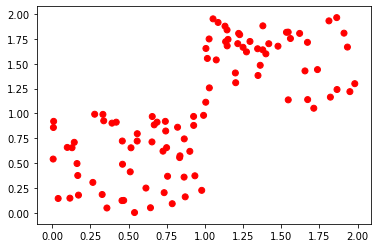

In [112]:
plt.scatter(x = toy_data[0], y = toy_data[1], c=colors)


In [ ]:
data_loader = DataLoader(n, d, batch_size, binary=True)
b_hist, func_val_hist, param_error, acc_hist = [], [], [], []
# Get the coefficients as solution to optimized sklearn function
logreg = LogisticRegression(penalty='none', solver='lbfgs', multi_class='multinomial')
logreg.fit(data_loader.X, data_loader.y)
norm_coeff = np.linalg.norm(logreg.coef_.ravel())
b_dual = Dual(b_init, None)

data_loader.shuffle_arrays()


In [57]:
from sklearn.linear_model import LogisticRegression

def train_logistic_regression(n, d, n_epoch, batch_size, b_init, l_rate):
    # Generate the data for a coefficient vector & init progress tracker!
    data_loader = DataLoader(n, d, batch_size, binary=True)
    b_hist, func_val_hist, param_error, acc_hist = [], [], [], []
    # Get the coefficients as solution to optimized sklearn function
    logreg = LogisticRegression(penalty='none', solver='lbfgs', multi_class='multinomial')
    logreg.fit(data_loader.X, data_loader.y)
    norm_coeff = np.linalg.norm(logreg.coef_.ravel())

    b_dual = Dual(b_init, None)

    # Start running the training loop
    for epoch in range(n_epoch):
        # Shuffle the batch identities at beginning of each epoch
        data_loader.shuffle_arrays()
        for batch_id in range(data_loader.num_batches):
            # Clear the gradient
            b_dual.init_grad()
            # Select the current batch & perform "mini-forward" pass
            X, y = data_loader.get_batch_idx(batch_id)
            y_pred_1, y_pred_2 = forward(X, b_dual)
            # Calculate the forward AD - real = func, dual = deriv
            current_dual, acc = binary_cross_entropy_dual(y, y_pred_1, y_pred_2)
            # Perform grad step & append results to the placeholder list
            b_dual.real -= l_rate*np.array(current_dual.dual).flatten()
            b_hist.append(b_dual.real)
            func_val_hist.append(current_dual.real)
            param_error.append(np.linalg.norm(logreg.coef_.ravel() - b_hist[-1])/norm_coeff)
            acc_hist.append(acc)

        if np.abs(param_error[-1] - param_error[-2]) < 0.00001:
            break

        if epoch % 1 == 0:
            print("Accuracy: {} | Euclidean Param Norm: {} | fct min: {}".format(acc, param_error[-1], current_dual.real))
    return b_hist, func_val_hist, param_error, acc_hist

In [58]:
    b, f, error, ac = train_logistic_regression(1000, 4, 40, 100, np.array([0, 0, 0, 0, 0]).astype(float), 0.005)

/Library/Python/3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ValueError: shapes (5,) and (100,5) not aligned: 5 (dim 0) != 100 (dim 0)

In [1]:
import math
class Var:
    """ stores a single scalar value and its gradient """

    def __init__(self, value, _children=(), _op=''):
        self.value = value
        self.grad = 0
        # internal variables used for autograd graph construction
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op # the op that produced this node, for graphviz / debugging / etc

    def __add__(self, other):
        other = other if isinstance(other, Var) else Var(other)
        out = Var(self.value + other.value, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Var) else Var(other)
        out = Var(self.value * other.value, (self, other), '*')

        def _backward():
            self.grad += other.value * out.grad
            other.grad += self.value * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Var(self.value**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.value**(other-1)) * out.grad
        out._backward = _backward

        return out

    def relu(self):
        out = Var(0 if self.value < 0 else self.value, (self,), 'ReLU')

        def _backward():
            self.grad += (out.value > 0) * out.grad
        out._backward = _backward
        return out
    
    def sigmoid(self):
        # doesn't work correctly yet
        out = Var((1/(1+math.exp(-self.value))), (self,), 'sigmoid')
        
        def _backward():
            self.grad += 1/(1+math.exp(-self.value))*(1-(1/(1+math.exp(-self.value))))
        out._backward = _backward
        return out

    def backward(self):
        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(value={self.value}, grad={self.grad})"
     
    
x = Var(0.5)
y = Var(4.2)
z = Var(4.5)
i = Var(2.2)



In [2]:
sorted_graph = []
visited = set()   
def topo_sort(vertex):
    if vertex not in visited:
        visited.add(vertex)
        for child in vertex._prev:
            topo_sort(child)
        sorted_graph.append(vertex)


In [3]:
[1,2] + [1]

[1, 2, 1]

In [23]:
import random


class Unit:
    def zero_grad(self):
        for p in self.params():
            p.grad = 0
            
    def params(self):
        return []

class Neuron(Unit):
    def __init__(self, n_inputs, activation_fun):
        # weight initialization
        self.weights = [Var(random.uniform(-1,1)) for i in range(n_inputs)]
        self.bias = Var(0)
        self.activation_fun = activation_fun
    
    def params(self):
        return self.weights + [self.bias]
    
    def __call__(self, inputs):
        weighted_sum = sum((weight_i * input_i for weight_i, input_i in zip(self.weights, inputs))) + self.bias
        activation = weighted_sum.relu() if self.activation_fun == "relu" else weighted_sum.sigmoid()
        return activation
    
    def __repr__(self):
        return f"relu Neuron with {len(self.weights)} inputs"
        
class Layer(Unit):
    def __init__(self, n_neurons, n_inputs, activation_fun="relu"):
        self.neurons = [Neuron(n_inputs, activation_fun) for i in range(n_neurons)]
    
    def __repr__(self):
        return self.neurons.__repr__()

    def params(self):
        return [p for n in self.neurons for p in n.params()]
    
class NeuralNetwork(Unit):
    def __init__(self):
        self.layers = [Layer(2,2),Layer(2,2)]
    
    def forward(self, inputs):
        result = inputs
        for i in self.layers:
            result = [j(result) for j in i.neurons]
        return result
        
    def params(self):
        return [p for layer in self.layers for p in layer.params()]
        
    def __repr__(self):
        return ",".join([i.__repr__() for i in self.layers])
        

def regularization(alpha, params, norm="l2"):
    if norm == "l2":
        reg_val = Var(sum([param.value**2 for param in params]))
    else:
        reg_val = Var(math.sqrt(sum([param.value**2 for param in params])))
    return reg_val
    
def loss(prediction, ground_truth):
    intermediate = [(i - j)**2 for i, j in zip(prediction, ground_truth)]
    temp = Var(0)
    for i in intermediate:
        temp = temp + i
    return temp

# def cross_entropy_loss(prediction, ground_truth):
    



In [24]:
random.seed(31)
random.gauss(1,.4)

1.1947507843544343

loss: 0.9997585332977175, grad: -0.08831431196788514
loss: 0.994478621599775, grad: -0.3281391417107534
loss: 0.9775121892022117, grad: -0.29557802595666116
loss: 0.9533595291415744, grad: -0.2970723945503267
loss: 0.9195711543473696, grad: -0.20539193314449083
loss: 0.8911686634365154, grad: -0.07507545069264054
loss: 0.8707196428239394, grad: -0.02496002976490136
loss: 0.8551411283725094, grad: 0.03440135859585691
loss: 0.8422056327006071, grad: 0.05085003356671511
loss: 0.8316038797853977, grad: 0.062171125838355046
loss: 0.8222510170210671, grad: 0.07227800944076432
loss: 0.8136189635614076, grad: 0.0744875194963883
loss: 0.8055515187372255, grad: 0.045880145566450314
loss: 0.7981658799380738, grad: 0.030520339543677943
loss: 0.7909969181604317, grad: 0.019815265717903013
loss: 0.7839141715923317, grad: 0.007236907340615661
loss: 0.7768597134925382, grad: -0.006543597553677408
loss: 0.7697939847806642, grad: -0.020991482234627448
loss: 0.7626934004766497, grad: -0.03567182996969598

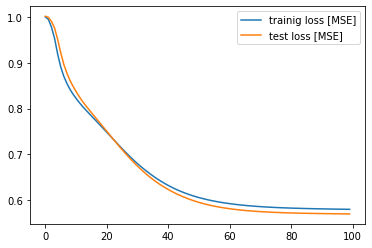

In [39]:

#def training(num_epochs, lr = 0.1):
num_epochs = 100
# generate random data
gt = [random.randint(0,1) for i in range(100)]
inputs = [[random.gauss(1,.2),random.gauss(1,.2)] if i == 1 
          else [random.gauss(0,.2),random.gauss(0,.2)] for i in gt]

gt = [[1,0] if i == 1 else [0,1] for i in gt]
import matplotlib.pyplot as plt

#plt.scatter([i[0] for i in inputs], [i[1] for i in inputs])



def training(num_epochs, data, g_truth, training_rate = 0.1):
    nn = NeuralNetwork()
    losses = []
    test_loss = []
    for i in range(num_epochs):
        # create loss
        loss_list = [loss(nn.forward(data_i), gt_i) for data_i, gt_i in zip(data[0:70], g_truth[0:70])]
        l = sum(loss_list) * (1.0/len(loss_list))
        losses.append(l.value)
        
        # generate gradients
        nn.zero_grad()
        l.backward()
        
        # test loss
        test_loss_list = [loss(nn.forward(data_i), gt_i) for data_i, gt_i in zip(data[70:], g_truth[70:])]
        test_loss.append((sum(test_loss_list) * (1.0/len(test_loss_list))).value)
        
        grads = 0
        #update gradients
        for p in nn.params():
            grads += p.grad
            p.value -= training_rate * p.grad
        
        print(f"loss: {l.value}, grad: {grads}")
    return nn, losses, test_loss

nn, losses, test_losses = training(num_epochs, inputs, gt)
plt.plot(losses, label="trainig loss [MSE]")
plt.plot(test_losses, label="test loss [MSE]")
plt.legend()
plt.savefig("/Users/jonas/Documents/ml/genericMlLib/test/loss.png")

In [10]:
# brew install graphviz
# pip install graphviz
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ value %.4f | grad %.4f }" % (n.value, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot


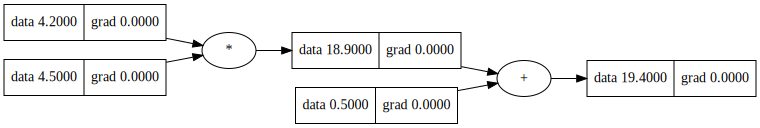

In [47]:
draw_dot(j)